# Control Operativo

In [2]:
import modulo_conn_sql as mcq
import numpy as np
import pandas as pd 
import datetime 
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin
import random
import math
import sqlalchemy as sa
import urllib
import seaborn as sns
import datetime as dt


def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)


def set_variacion_porcentual( dataf, column_name, grupo):
    nombre_nueva_columna = 'diff_'+column_name
    dataf[nombre_nueva_columna] = dataf[column_name].diff()
    dataf[nombre_nueva_columna] = dataf[nombre_nueva_columna] / dataf[column_name]
    mask = dataf[grupo] != dataf[grupo].shift(1)
    dataf[nombre_nueva_columna][mask] = np.nan
    return dataf[nombre_nueva_columna]

def set_variacion_nominal( dataf, column_name, grupo):
    nombre_nueva_columna = 'diff_'+column_name
    dataf[nombre_nueva_columna] = dataf[column_name].diff()
    mask = dataf[grupo] != dataf[grupo].shift(1)
    dataf[nombre_nueva_columna][mask] = np.nan
    return dataf[nombre_nueva_columna]

In [8]:
#Variables 
pais='Colombia'

#rangos de fecha
#fin_historia = datetime.date.today()
fin_historia = datetime.date(2022,3,31)
#inicio_historia = fin_historia - datetime.timedelta(30 * 2) - MonthBegin(1)
inicio_historia= datetime.date(2022,2,1)

#agrego informacion geografica        
nombre_cluster = querySQL( "SELECT Pais, Centro, Ciudad_Cluster as Ciudad, [Desc Cluster] as Cluster, [Planta Unica] as PlantaUnica FROM SCAC_AT1_NombreCluster where Pais = ?" , (pais) )

#flota asignada
df_flota_asignada = querySQL( "select * from SCAC_AV13_CamionesAsignados where Pais = ? and FechaEntrega between ? and ?" , (pais, inicio_historia.strftime("%Y-%m-%d"), fin_historia.strftime("%Y-%m-%d")) )
df_flota_asignada['year_month'] = df_flota_asignada['FechaEntrega'].dt.to_period('M')
df_flota_asignada.rename(columns = {'Planta Unica':'Planta'}, inplace = True)

#flota rodando
df_flota_rodando = querySQL( "select * from SCAC_AV14_CamionesRodandoDiario where Pais = ? and FechaEntrega between ? and ?" , (pais, inicio_historia.strftime("%Y-%m-%d"), fin_historia.strftime("%Y-%m-%d")) )
df_flota_rodando['year_month'] = df_flota_rodando['FechaEntrega'].dt.to_period('M')
df_flota_rodando.rename(columns = {'Planta Unica':'Planta'}, inplace = True)

#agrego calendario        
calendario = querySQL( "SELECT * FROM SCAC_AT3_DiasHabilesFuente where Pais = ? and [Fecha de entrega] BETWEEN ? AND ?" , (pais, inicio_historia.strftime("%Y-%m-%d"), fin_historia.strftime("%Y-%m-%d") ) )
df_calendario_detalle = calendario
df_calendario_detalle.rename(columns={'Fecha de entrega': 'FechaEntrega'}, inplace = True)

calendario['year_month'] = calendario['FechaEntrega'].dt.to_period('M')
calendario = calendario.groupby(['pais', 'year_month'])['Días_Operativos_Acum'].max().reset_index()

#Dataset de los despachos
df_serv = querySQL( "{CALL SCAC_AP10_dataset_servicios_rango (?,?,?)}" , (pais, inicio_historia.strftime("%Y-%m-%d"), fin_historia.strftime("%Y-%m-%d")) )
df_serv = df_serv.fillna(value=np.nan)
df_serv['year_month'] = df_serv.FechaEntrega.dt.to_period('M')
#Se agrega pais
df_serv = pd.merge(df_serv,nombre_cluster[['Pais','Centro']], on='Centro')

#Dataset de la programación
df_pedidos = querySQL( "{CALL SCAC_AP11_Dataset_Pedidos_rango (?,?,?)}" , (pais, inicio_historia.strftime("%Y-%m-%d"), fin_historia.strftime("%Y-%m-%d")) )
df_pedidos = df_pedidos.fillna(value=np.nan)
df_pedidos['year_month'] = df_pedidos.FechaEntrega.dt.to_period('M')

## Ensamblaje

In [9]:
#cumplimiento
df_cumpto = df_serv[(df_serv['Entrega'] != '') & (df_serv['Estatus'] == 'Normal') ].groupby(['Planta', 'year_month'])['Cumplimiento'].agg(['sum','count']).reset_index()
df_cumpto['cumplimiento_mes'] = df_cumpto['sum'] / df_cumpto['count']
df_cumpto = df_cumpto.drop(['sum','count'], axis=1)

#Volumen y media diaria
df_ve = df_serv[(df_serv['Entrega'] != '') & (df_serv['Estatus'] == 'Normal') ].groupby(['year_month','Planta'])['VolPartida'].agg(['sum']).reset_index()
df_ve = df_ve.rename(columns = {'sum':'volumen_entregado'})
df_ve = pd.merge(df_ve, calendario, on='year_month')
df_ve['media_diaria'] = df_ve['volumen_entregado'] / df_ve['Días_Operativos_Acum']

#Distancia
df_distancia = df_serv[(df_serv['Entrega'] != '') & (df_serv['Estatus'] == 'Normal') ].groupby(['year_month','Planta'])['DistanciaPlantaObraKm'].agg(['sum','mean']).reset_index()
df_distancia = df_distancia.rename(columns = {'mean':'DistanciaRecorrida', 'sum':'Distancia_total_flota'})
df_distancia['Distancia_total_flota'] = df_distancia['Distancia_total_flota'] * 2
df_distancia = pd.merge(df_distancia, df_ve, on=['year_month', 'Planta'])
df_distancia['km_por_m3'] = df_distancia['Distancia_total_flota'] / df_distancia['volumen_entregado']
df_distancia = df_distancia[['year_month', 'Planta', 'DistanciaRecorrida', 'km_por_m3']]

#Tiempo de ciclo
#df_ciclo = df_serv[(df_serv['Entrega'] != '') & (df_serv['Estatus'] == 'Normal') ].groupby(['year_month','Planta'])['TiempoCargue', 'TiempoAlistamiento', 'TiempoIda', 'TiempoObra','TiempoRegreso'].mean().reset_index()
df_ciclo_0 = df_serv[(df_serv['TiempoCargue'] > 3) & (df_serv['TiempoCargue'] < 150) & (df_serv['Entrega'] != '') & (df_serv['Estatus'] == 'Normal') ].groupby(['year_month','Planta'])['TiempoCargue'].mean().reset_index()
df_ciclo_1 = df_serv[(df_serv['TiempoAlistamiento'] > 10) & (df_serv['TiempoAlistamiento'] < 60) & (df_serv['Entrega'] != '') & (df_serv['Estatus'] == 'Normal') ].groupby(['year_month','Planta'])['TiempoAlistamiento'].mean().reset_index()
df_ciclo_2 = df_serv[(df_serv['TiempoIda'] > 10) & (df_serv['TiempoIda'] < 240) & (df_serv['Entrega'] != '') & (df_serv['Estatus'] == 'Normal') ].groupby(['year_month','Planta'])['TiempoIda'].mean().reset_index()
df_ciclo_3 = df_serv[(df_serv['TiempoObra'] > 10) & (df_serv['TiempoObra'] < 240) & (df_serv['Entrega'] != '') & (df_serv['Estatus'] == 'Normal') ].groupby(['year_month','Planta'])['TiempoObra'].mean().reset_index()
df_ciclo_4 = df_serv[(df_serv['TiempoObra'] > 10) & (df_serv['TiempoRegreso'] > 10) & (df_serv['TiempoRegreso'] < 240) & (df_serv['Entrega'] != '') & (df_serv['Estatus'] == 'Normal') ].groupby(['year_month','Planta'])['TiempoRegreso'].mean().reset_index()

df_ciclo = pd.merge(df_ciclo_0, df_ciclo_1, on =['year_month','Planta'])
df_ciclo = pd.merge(df_ciclo, df_ciclo_2, on = ['year_month','Planta'])
df_ciclo = pd.merge(df_ciclo, df_ciclo_3, on = ['year_month','Planta'])
df_ciclo = pd.merge(df_ciclo, df_ciclo_4, on = ['year_month','Planta'])
df_ciclo['ciclo'] = df_ciclo['TiempoCargue'] + df_ciclo['TiempoAlistamiento'] + df_ciclo['TiempoIda']+ df_ciclo['TiempoObra'] + df_ciclo['TiempoRegreso']

#OCR
df_ao = df_pedidos.groupby(['year_month','Planta'])['AceptacionOrdenes'].agg(['sum', 'count']).reset_index()
df_ao['AO'] = df_ao['sum']/df_ao['count']
df_ao = df_ao.drop(['sum','count'], axis= 1)

#Cancelaciones
df_canc = pd.pivot_table(
    df_pedidos,
    index = ['year_month', 'Planta'],
    values = ['VolCanceladoCliente', 'VolPartida'],
    aggfunc = np.sum
)
df_canc = df_canc.reset_index()
df_canc['cancelacionCliente'] =df_canc['VolCanceladoCliente']/df_canc['VolPartida']
df_canc = df_canc.drop(['VolCanceladoCliente', 'VolPartida'], axis= 1)

#Flota asignadas
df_asignada = df_flota_asignada[df_flota_asignada['Estatus'] == 'Operativo'].groupby(['year_month','Planta'])['ID'].count().reset_index()
df_asignada.rename(columns={'ID':'FlotaAsignada'}, inplace = True)

#Flota rodando
df_rodando = df_flota_rodando.groupby(['year_month', 'FechaEntrega', 'Planta'])['Placa Vehículo 1'].count().reset_index()
df_rodando = pd.merge(df_rodando,df_calendario_detalle[['FechaEntrega', 'Días_Operativos']], on='FechaEntrega' )
df_rodando.rename(columns={'Placa Vehículo 1': 'FlotaRodando'}, inplace =True)
df_rodando = df_rodando[df_rodando['Días_Operativos'] == 1].groupby(['year_month', 'Planta'])['FlotaRodando'].mean().reset_index()

#productividad
df_dias_operativo = df_flota_rodando.groupby(['year_month', 'Planta'])['FechaEntrega'].nunique().reset_index()

df_volumen_diasoperativos = pd.merge( df_serv,df_calendario_detalle[['FechaEntrega', 'Días_Operativos']], on='FechaEntrega' )
df_volumen_diasoperativos = df_volumen_diasoperativos[df_volumen_diasoperativos['Días_Operativos']== 1]
df_volumen_diasoperativos = df_volumen_diasoperativos[(df_volumen_diasoperativos['Entrega'] != '') & (df_volumen_diasoperativos['Estatus'] == 'Normal') ].groupby(['year_month','Planta'])['VolPartida'].agg(['sum']).reset_index()
df_volumen_diasoperativos = df_volumen_diasoperativos.rename(columns = {'sum':'volumen_diasoperativos'})

df_productividad = pd.merge(df_rodando, df_volumen_diasoperativos, on =['year_month', 'Planta'])
df_productividad = pd.merge(df_productividad, df_dias_operativo, on=['year_month', 'Planta'])
df_productividad['FlotaRodando'] = df_productividad['FlotaRodando'].apply(np.ceil)
df_productividad['productividad_diaria'] = (df_productividad['volumen_diasoperativos'] / df_productividad['FlotaRodando'])/ df_productividad['FechaEntrega']
df_productividad = df_productividad[['year_month', 'Planta', 'productividad_diaria', 'FechaEntrega']]
df_productividad.rename(columns={'FechaEntrega':'DiasOperativosTrabajados'}, inplace =True)

#concatenacion de cada dataframe

df = pd.merge(df_cumpto, df_ve, on =['year_month', 'Planta']).drop('pais', axis=1)
df = pd.merge(df, df_ciclo[['year_month', 'Planta', 'TiempoObra', 'ciclo']], on =['year_month', 'Planta'])
df = pd.merge(df, df_distancia, on =['year_month', 'Planta'])
df = pd.merge(df, df_ao, on =['year_month', 'Planta'])
df = pd.merge(df, df_canc, on =['year_month', 'Planta'])
df = pd.merge(df, df_asignada, on =['year_month', 'Planta'])
df = pd.merge(df, df_rodando, on =['year_month', 'Planta'])
df = pd.merge(df, df_productividad, on =['year_month', 'Planta'])

#ajustes finales
df['year_month'] = df['year_month'].astype(str)
df_cluster = nombre_cluster.groupby(['Cluster', 'PlantaUnica'])['Pais'].nunique().reset_index()
df_cluster.rename(columns = {'PlantaUnica':'Planta'}, inplace = True)

df = pd.merge(df, df_cluster[['Cluster', 'Planta']], on='Planta')


# Identificacion de variaciones significativas

In [10]:
columnas_analisis_porcentual = ['volumen_entregado', 
                     'media_diaria','cumplimiento_mes', 
                     'TiempoObra', 
                     'ciclo', 
                     'DistanciaRecorrida', 
                     'km_por_m3', 
                     'AO', 
                     'cancelacionCliente', 
                     'productividad_diaria']
columnas_analisis_nominal = ['FlotaAsignada','FlotaRodando']

for i, var in enumerate(columnas_analisis_porcentual):
    df['diff_'+var] = set_variacion_porcentual(df, var, 'Planta')
    
for i, var in enumerate(columnas_analisis_nominal):
    df['diff_'+var] = set_variacion_nominal(df, var, 'Planta')

<ipython-input-2-3d65139cd922>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataf[nombre_nueva_columna][mask] = np.nan
<ipython-input-2-3d65139cd922>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataf[nombre_nueva_columna][mask] = np.nan


In [13]:
periodo_target = '2022-03'
df = df[df['year_month'] == periodo_target]
df

,Planta,year_month,cumplimiento_mes,volumen_entregado,Días_Operativos_Acum,media_diaria,TiempoObra,ciclo,DistanciaRecorrida,km_por_m3,...,diff_cumplimiento_mes,diff_TiempoObra,diff_ciclo,diff_DistanciaRecorrida,diff_km_por_m3,diff_AO,diff_cancelacionCliente,diff_productividad_diaria,diff_FlotaAsignada,diff_FlotaRodando
1,CO-PLANTA 240,2022-03,0.864206,9455.25,26,363.663462,63.796642,176.012983,17.837014,5.417932,...,0.062531,0.040547,0.035915,0.149965,0.258933,0.005086,0.269967,-0.198409,1.0,2.150641
3,CO-PLANTA BARRANQUILLA,2022-03,0.729916,9823.10,26,377.811538,66.408917,192.070891,12.374229,3.292874,...,0.042918,0.038793,0.014629,-0.058111,-0.058318,0.132443,0.051977,-0.077239,2.0,0.583333
5,CO-PLANTA BELLO,2022-03,0.808679,3388.50,26,130.326923,56.161616,183.916258,13.056083,3.907000,...,-0.098548,-0.069803,-0.058367,-0.198317,-0.166209,0.003831,0.450542,0.055900,1.0,-0.339744
7,CO-PLANTA BOSA,2022-03,0.893868,6025.00,26,231.730769,68.397313,200.505210,4.484310,1.262305,...,0.178346,-0.047365,-0.093766,-0.092834,-0.087249,-0.005416,0.182880,0.052804,-3.0,-2.006410
9,CO-PLANTA CALI,2022-03,0.823144,6107.00,26,234.884615,66.591022,191.394475,9.941450,2.969249,...,0.137801,0.007237,0.036375,-0.025532,-0.028998,0.086444,-0.021301,-0.160039,2.0,0.442308
11,CO-PLANTA CALI SUR,2022-03,0.884656,6494.00,26,249.769231,67.152263,178.441611,14.264767,4.151588,...,-0.015251,0.057061,0.040865,0.013621,-0.002739,0.009819,0.101198,0.014783,0.0,0.750000
13,CO-PLANTA CALLE 170,2022-03,0.870858,8092.00,26,311.230769,60.192537,173.481134,7.822610,2.275633,...,0.047390,0.099050,0.058076,0.070141,0.037215,0.013412,-0.021784,0.050611,1.0,0.352564
15,CO-PLANTA CARTAGENA,2022-03,0.905455,5660.75,26,217.721154,53.736287,173.845967,10.606548,3.091605,...,0.042314,0.081644,0.035082,-0.057888,-0.045866,0.027166,0.015683,-0.119695,0.0,-0.804487
17,CO-PLANTA CON. IBAGUE,2022-03,0.738028,9800.00,26,376.923077,79.003584,193.211360,6.237094,1.807484,...,0.018064,0.073154,-0.008037,-0.081696,-0.094601,0.090604,-0.115352,0.071606,1.0,1.586538
19,CO-PLANTA CUCUTA,2022-03,0.884434,2911.25,26,111.971154,63.495208,169.046128,9.098666,2.650294,...,-0.063525,-0.010716,0.067419,0.035844,0.005960,0.217237,0.200997,0.013407,1.0,0.012821


## Actualización de datos en SQL

In [14]:
params = urllib.parse.quote_plus("DRIVER={ODBC Driver 17 for SQL Server};SERVER=USCLDBITVMP01;DATABASE=BI_Tableau;UID=usertableau;PWD=usertableau$")
engine = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)
        
df.to_sql("SCAC_AT39_control_operativo", engine, index=False, if_exists="append", schema="dbo")

In [6]:
df[df['Planta'] == 'CO-PLANTA 240'].head(20).T

,0
Planta,CO-PLANTA 240
year_month,2022-03
cumplimiento_mes,0.864206
volumen_entregado,9455.25
Días_Operativos_Acum,26
media_diaria,363.663
TiempoObra,63.7966
ciclo,176.013
DistanciaRecorrida,17.837
km_por_m3,5.41793


<AxesSubplot:>

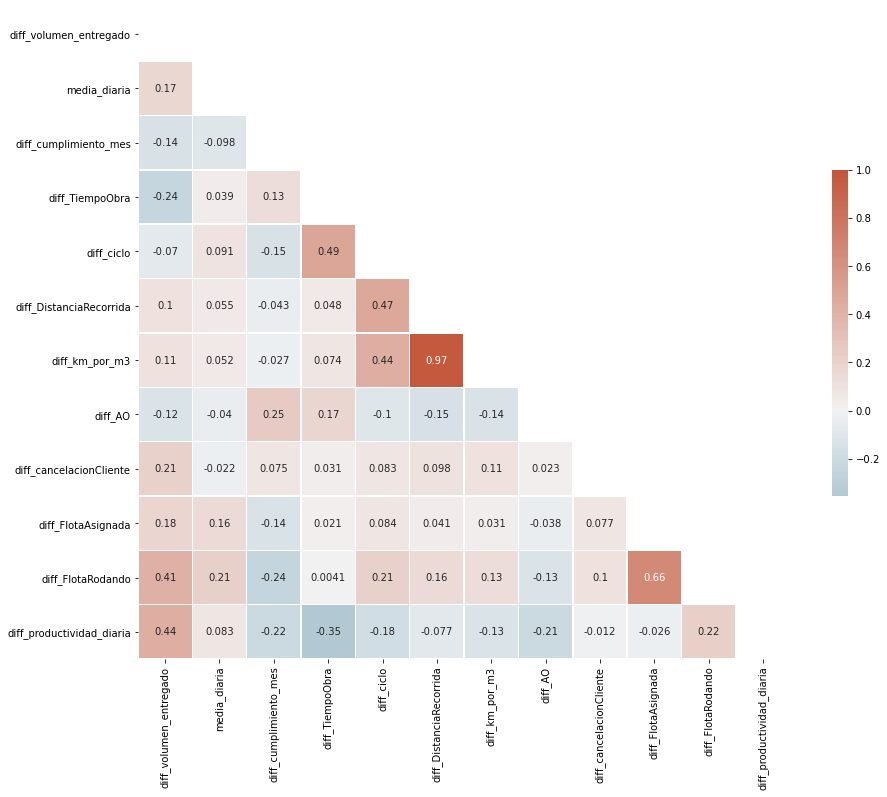

In [73]:
columnas_analisis_variaciones = ['diff_volumen_entregado', 
                     'media_diaria',
                     'diff_cumplimiento_mes', 
                     'diff_TiempoObra', 
                     'diff_ciclo', 
                     'diff_DistanciaRecorrida', 
                     'diff_km_por_m3', 
                     'diff_AO', 
                     'diff_cancelacionCliente', 
                     'diff_FlotaAsignada', 
                     'diff_FlotaRodando', 
                     'diff_productividad_diaria']
# Análisis de correlaciones
df_correlation = df[columnas_analisis_variaciones].corr()

mask = np.triu(np.ones_like(df_correlation, dtype=bool))
f, ax = plt.subplots(figsize=(15, 12))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_correlation, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)